# Proyecto R: Análisis Exploratorio de Datos

## New York City Airbnb Open Data

Nombre: Vladimir Sagot Muñoz

Curso: Lenguajes de Programación Orientados al Análisis de Datos

Profesor: Sergio Morales Esquivel

---

## Introducción

Para elaborar el proyecto de análisis exploratorio de datos (EDA) en R del curso, se utilizará el dataset "New York City Airbnb Open Data". El cual puede ser encontrado en el siguiente enlace: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

El dataset seleccionado, incluye la información -con corte al año 2019- sobre el estado de todos los Airbnb en la ciudad de Nueva York (NYC, de ahora en adelante). Este representa un valioso insumo para realizar la exploración de datos y la búsqueda de comportamientos alrededor de la industria de hospedaje en la ciudad.

## Características del dataset seleccionado

Este dataset cuenta con 16 atributos y cerca de 49 mil vistas. Cada vista se refiere a un único Airbnb en la ciudad, con su respectiva información al año 2019.

Con respecto a sus atributos, el mismo cuenta con uno de tipo temporal, que hace referencia a cuándo fue su última calificación. También, contiene atributos de tipo geográfico, los cuales se muestran a través de coordenadas geográficas (latitud y longitud), así como de su respectiva localización y barrio (categóricos/factors).


### Nomenclatura

- **id:** Identificador único de cada Airbnb en NYC.
- **name:** Título con el que el dueño nombre a su Airbnb.
- **host_id:** Identificador único sobre el dueño del Airbnb.
- **host_name:** Nombre del dueño del Airbnb.
- **neighbourhood_group:** Se refiere al "borough" (división administrativa territorial en EE.UU.) en donde se ubica el Airbnb.
- **neighbourhood:** El barrio al que pertenece el Airbnb.
- **latitude:** Latitud donde se ubica el Airbnb.
- **longitude:** Longitud donde se ubica el Airbnb.
- **room_type:** Categoría del Airbnb (Private room | Shared room | Entire home/apt)
- **price:** Precio por noche del Airbnb.
- **minimum_nights:** Mínimo de noches para poder reservar un Airbnb.
- **number_of_reviews:** Número de calificaciones de un Airbnb.
- **last_review:** Fecha de la última calificación dada al Airbnb.
- **reviews_per_month:** Promedio de calificaciones mensuales que recibe el Airbnb.
- **calculated_host_listings_count:** Número de Airbnbs asociados al host del Airbnb en específico.
- **availability_365:** La disponibilidad de días por año de un Airbnb. Si es 0 es porque no existe la información al momento de corte o porque no estaba disponible para ser reservado en ese momento.

---

## Objetivos

### Objetivo general

Conocer sobre el estado general de los Airbnb en la ciudad de Nueva York en el año 2019.

### Objetivos específicos

- Describir el estado de precios de Airbnbs por zona en la ciudad de Nueva York.

- Reconocer los barrios más populares para quedarse en Airbnbs de la ciudad de Nueva York.

- Describir el tipo de estadia en los Airbnbs de la ciudad de Nueva York.

---

## Ingestión de datos

Al tratarse de un dataset bastante popular, el mismo ya se encuentra bastante depurado para ser analizado. Por lo que se procede a realizar el proceso para cargar las librerías que se usarán, así como el dataset.

In [373]:
install.packages("tidyverse")
install.packages("ggcorrplot")
install.packages("leaflet")
install.packages("geojsonio")
install.packages("viridis")
install.packages("glue")

Warning message:
"package 'tidyverse' is in use and will not be installed"Warning message:
"package 'ggcorrplot' is in use and will not be installed"Warning message:
"package 'leaflet' is in use and will not be installed"Warning message:
"package 'geojsonio' is in use and will not be installed"Warning message:
"package 'viridis' is in use and will not be installed"Warning message:
"package 'glue' is in use and will not be installed"

In [372]:
library(tidyverse)
library(ggcorrplot)
library(leaflet)
library(geojsonio)
library(viridis)
library(glue)

Para cargar el dataset como un tibble, se procede a cargar el archivo CSV. Aunque no es necesario, se le indica al método de carga de qué tipo de dato debe ser cada columna.

Las columnas "neighbourhood_group", "neighbourhood" y "room_type", por su lógica de elemento clasificador, se cargan como elementos de tipo factor. De esta forma se ahorra espacio en su método de almacenamiento en memoria.

In [172]:
df <- read_csv("AB_NYC_2019.csv",
              col_types = cols(
                  id = col_integer(),
                  name = col_character(),
                  host_id = col_integer(),
                  host_name = col_character(),
                  neighbourhood_group = col_factor(),
                  neighbourhood = col_factor(),
                  latitude = col_double(),
                  longitude = col_double(),
                  room_type = col_factor(),
                  price = col_double(),
                  minimum_nights = col_integer(),
                  number_of_reviews = col_integer(),
                  last_review = col_date(format = ""),
                  reviews_per_month = col_double(),
                  calculated_host_listings_count = col_integer(),
                  availability_365 = col_integer()
              ))

df_prices_without_outliers <- df %>% filter(price <= 1000)

---

## Análisis de datos

### Mirada general de NYC

La ciudad de Nueva York está divida por "boroughs" (división administrativa territorial en EE.UU.) y estos se dividen además en barrios. Ambas unidades territoriales serán de mucha utilidad para el análisis de datos.

A continuación se despliega un mapa de la división administrativa general de NYC para tener una noción espacial de la misma. El mapa se obtiene del siguiente enlace: https://data.beta.nyc/dataset/nyc-borough-boundaries

In [43]:
nyc_boroughs_geo <- geojsonio::geojson_read("NYC_BOROUGHS.json", what = "sp")

In [190]:
pal <- colorFactor(palette = "Set2", nyc_boroughs_geo$borough)

m <- leaflet(nyc_boroughs_geo) %>%

    setView(lng = -74.0060, lat = 40.7128, zoom = 10) %>%

    addProviderTiles(providers$CartoDB.Positron) %>% 

    addPolygons(
        weight = 1,
        opacity = 1,
        color = ~pal(borough),
        label = nyc_boroughs_geo$borough,
        dashArray = "3",
        fillOpacity = 0.8,
            highlight = highlightOptions(
            weight = 2,
            color = ~pal(borough),
            dashArray = "",
            fillOpacity = 1,
            bringToFront = TRUE)) %>%

    addLegend("bottomright",
              pal = pal,
              values = ~nyc_boroughs_geo$borough,
              title = "Boroughs",
              opacity = 1)

m

HTML widgets cannot be represented in plain text (need html)

### Búsqueda de correlaciones relevantes

Como primer paso para explorar el dataset de Airbnbs, se procede a buscar alguna correlación relevante entre los distintos datos obtenidos.

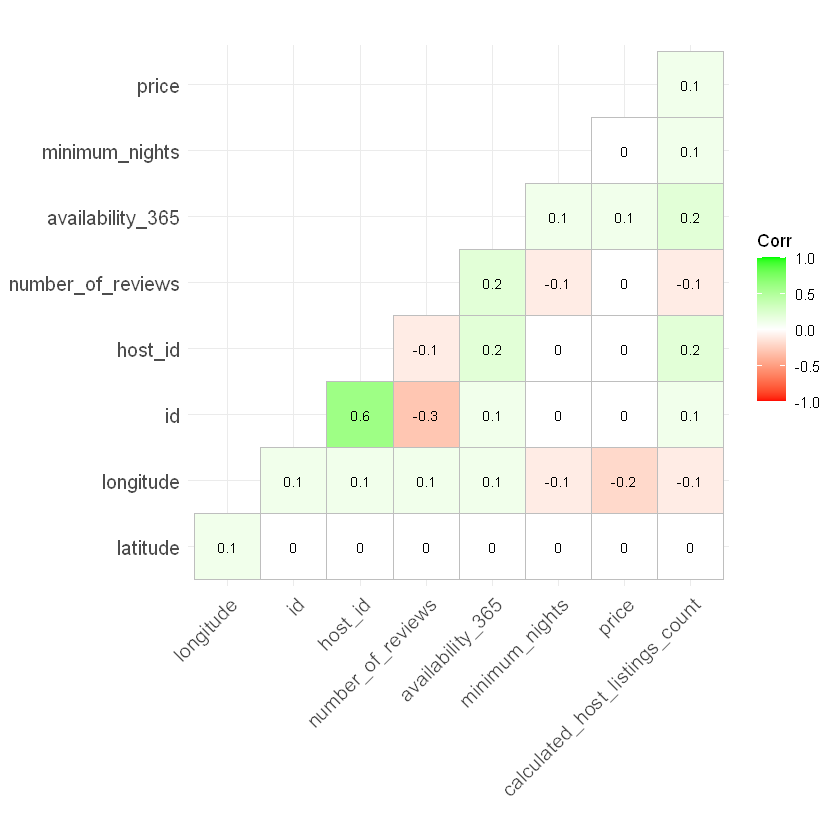

In [22]:
df_numeric <- df %>% select(where(is.numeric)) %>% select(-reviews_per_month)

corr <- round(cor(df_numeric), 1)

ggcorrplot(corr, hc.order = TRUE, type = "lower", lab = TRUE, lab_size = 3, method="square", colors = c("red", "white", "green"))

Como se muestra en el gráfico anterior, no existen en una primera mirada correlaciones relevantes entre los distintos datos del dataset. Por lo que se procederá a estudiar el mismo en su ámbito espacial a través de mapas.

### Distribución general de los Airbnb en NYC

Para proceder en esta sección, realizaremos un conteo geográfico de Airbnbs por barrio en NYC. Para lo cual utilizaremos el siguiente mapa de la ciudad: https://data.beta.nyc/dataset/pediacities-nyc-neighborhoods

De esta forma se contará su densidad por zona, y podremos conocer cuáles son los barrios con una mayor cantidad de los mismos.

In [128]:
nyc_neighborhoods_geo <- geojsonio::geojson_read("NYC_NEIGHBORHOODS.json", what = "sp")

# Conteo de Airbnbs por barrio en NYC
nyc_airbnbs_per_neighborhoods <- df %>%
    group_by(neighbourhood) %>%
    summarise(count = n())

# Se combina la información de Airbnbs por barrio con el mapa, para su diagramación
nyc_airbnbs_info_map <- sp::merge(
    nyc_neighborhoods_geo,
    nyc_airbnbs_per_neighborhoods,
    by.x="neighborhood",
    by.y="neighbourhood")

In [129]:
labels <- sprintf(
  "<strong>%s</strong><br/>Airbnbs: %g",
  nyc_airbnbs_info_map$neighborhood, nyc_airbnbs_info_map$count
) %>% lapply(htmltools::HTML)

pal <- colorNumeric(
    palette = "PuRd",
    domain = nyc_airbnbs_per_neighborhoods$count)

m <- leaflet(nyc_airbnbs_info_map) %>%

    setView(lng = -74.0060, lat = 40.7128, zoom = 10) %>%

    addProviderTiles(providers$CartoDB.Positron) %>% 

    addPolygons(
        fillColor = ~pal(count),
        weight = 1,
        opacity = 1,
        color = "black",
        dashArray = "3",
        fillOpacity = 0.8,
            highlight = highlightOptions(
            weight = 2,
            color = "#666",
            dashArray = "",
            fillOpacity = 1,
            bringToFront = TRUE),
        label = labels) %>%

    addLegend("bottomright",
              pal = pal,
              values = ~nyc_airbnbs_info_map$count[!is.na(count)],
              title = "Airbnbs",
              opacity = 1)

m

HTML widgets cannot be represented in plain text (need html)

Además, a continuación se presentan los datos de los barrios con mayor densidad de Airbnbs, así como la recopilación total de Airbnbs por división administrativa.

In [77]:
df %>% group_by(neighbourhood_group, neighbourhood) %>% summarise(count = n()) %>% arrange(desc(count)) %>% head()

`summarise()` has grouped output by 'neighbourhood_group'. You can override using the `.groups` argument.


neighbourhood_group neighbourhood      count
1 Brooklyn            Williamsburg       3920 
2 Brooklyn            Bedford-Stuyvesant 3714 
3 Manhattan           Harlem             2658 
4 Brooklyn            Bushwick           2465 
5 Manhattan           Upper West Side    1971 
6 Manhattan           Hell's Kitchen     1958

In [76]:
df %>% group_by(neighbourhood_group) %>% summarise(count = n()) %>% arrange(desc(count))

neighbourhood_group count
1 Manhattan           21661
2 Brooklyn            20104
3 Queens               5666
4 Bronx                1091
5 Staten Island         373

Como se puede observar, los Airbnbs están altamente concentrados en algunos barrios de la ciudad. Existiendo cinco barrios con más de 2.000 Airbnbs.

Además, Brooklyn tiene los dos barrios con más Airbnbs, pero Manhattan es la división administrativa con mayor cantidad de los mismos.

Conociendo esta información sobre la concentración de Airbnbs. Podemos adentrarnos a explorar el tema del precio según la zona.

### Precios de los Airbnbs en NYC

A continuación, de forma breve y para conocer si existe una tendencia en adelantado, colocaremos en el mapa de la ciudad los 50 Airbnbs con mayor precio por noche de la ciudad.

In [351]:
df_head_desc_price <- df %>% arrange(desc(price)) %>% head(50)

m <- leaflet(df_head_desc_price) %>% addTiles() %>%
    addCircleMarkers(~longitude, ~latitude, stroke = FALSE, fillOpacity = 0.8, clusterOptions = markerClusterOptions()) %>%
    addProviderTiles(providers$CartoDB.Positron)

m

HTML widgets cannot be represented in plain text (need html)

A simple vista se puede observar una concentración de los Airbnbs con mayor precio por noche en Manhattan.

#### Eliminar valores outliers en los precios de Airbnbs

Antes de continuar avanzando con el análisis es importante tomar en cuenta la cantidad de Airbnbs que tienen precios por noche sumamente altos y que representan una cantidad reducida. Ya que estos pueden modificar de gran forma los distintos cálculos por realizar. Para esto procedemos a visualizar en un boxplot la distribución de los precios por noche.

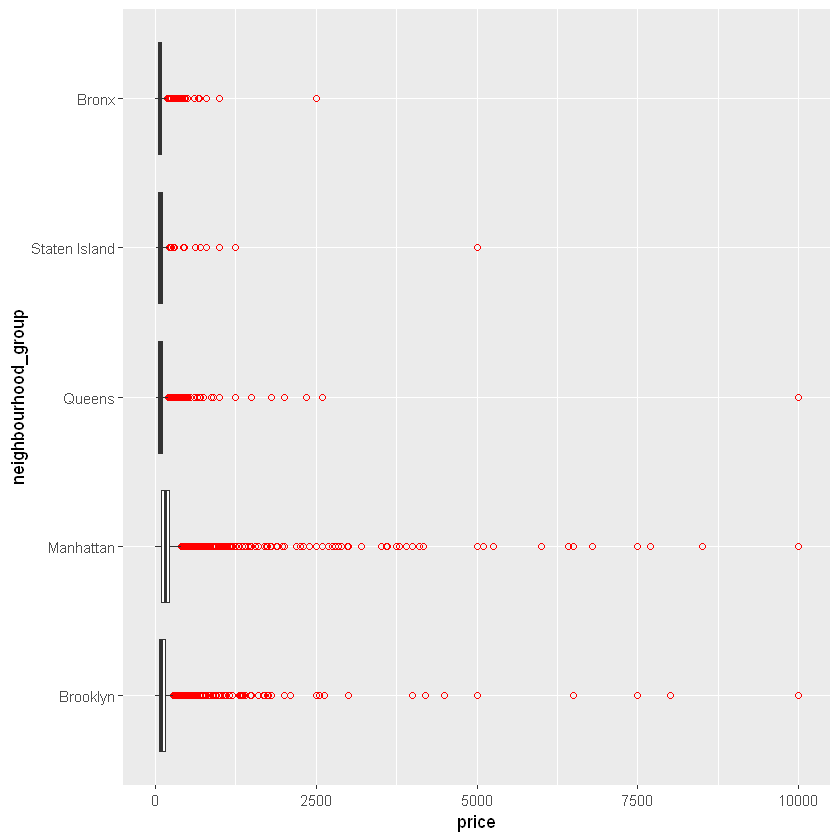

In [362]:
p <- ggplot(df, aes(price, neighbourhood_group))
p + geom_boxplot(outlier.colour = "red", outlier.shape = 1)

Como se muestra anteriormente, existe una reducida cantidad de Airbnbs con precios sumamente altos que para efectos de un analisis más realista vale la pena no considerar.

De una forma no cientifica, y guiada a través de lo visual, se procederá a remover los valores que cuentan como outliers.

In [165]:
df %>% filter(price > 1000) %>% summarize(n())

n()
1 239

In [168]:
df %>% filter(price <= 1000) %>% summarize(n())

n()  
1 48656

**<span style="background-color: #FFFF00">Tibble que se utilizará para explorar datos sobre los precios.</span>**

In [366]:
df_prices_without_outliers <- df %>% filter(price <= 1000)

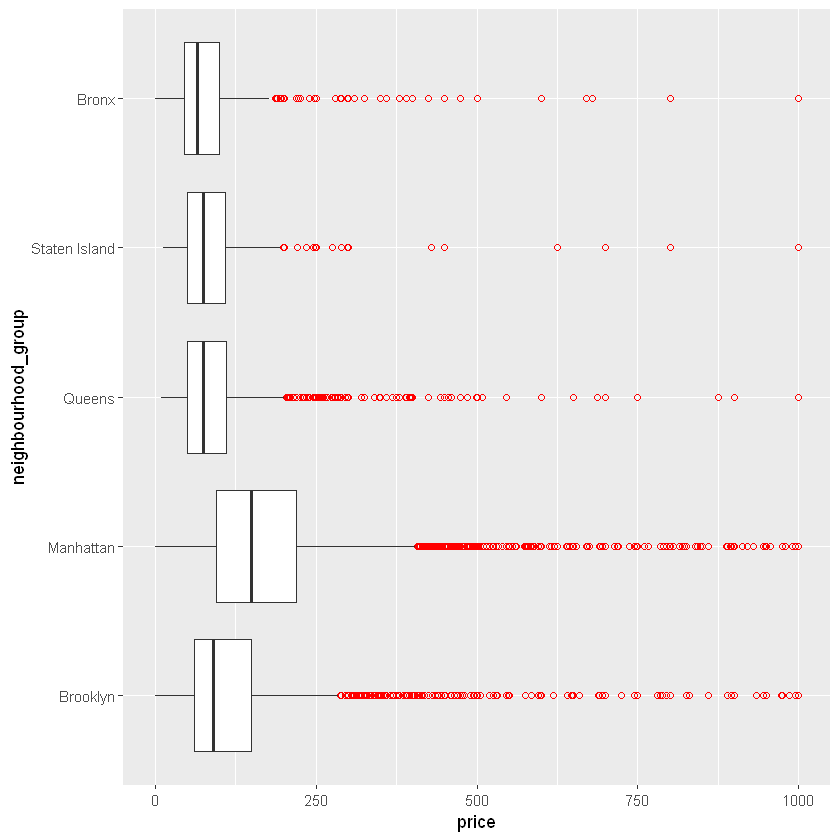

In [367]:
p <- ggplot(df_prices_without_outliers, aes(price, neighbourhood_group))
p + geom_boxplot(outlier.colour = "red", outlier.shape = 1)

#### Análisis de la información de precios sin valores outliers

Una vez eliminados los valores que pueden distorsionar el proceso de análisis, se vuelve a repetir la visualización de marcas con los 50 Airbnbs de mayor precio por noche en NYC.

In [350]:
df_head_desc_price <- df_prices_without_outliers %>% arrange(desc(price)) %>% head(50)

m <- leaflet(df_head_desc_price) %>% addTiles() %>%
    addCircleMarkers(~longitude, ~latitude, stroke = FALSE, fillOpacity = 0.8, clusterOptions = markerClusterOptions()) %>%
    addProviderTiles(providers$CartoDB.Positron)

m

HTML widgets cannot be represented in plain text (need html)

La distribución de Airbnbs con mayor precio por noche sin los outliers, no cambia con respecto a la versión anterior generada del mapa, solo contra más en Manhattan estas ubicaciones.

A continuación se genera una tabla que resume el promedio de costo por noche según la división administrativa. La cual nos ayudará a empezar a conocer más sobre los precios en NYC.

In [175]:
df_prices_without_outliers %>%
    group_by(neighbourhood_group) %>%
    summarise(price_mean = mean(price)) %>%
    arrange(desc(price_mean))

neighbourhood_group price_mean
1 Manhattan           178.93629 
2 Brooklyn            117.80793 
3 Staten Island        98.58491 
4 Queens               95.00831 
5 Bronx                85.28349

Como se observó en la distribución de los 50 Airbnbs con mayor precio por noche y ahora con el promedio por división administrativa, Manhattan es el lugar con el promedio de precio por noche más alto, cerca de $179.

Es importante poder analizar a mayor detalle el promedio de costo por noche según la zona, para ver en dónde existen mayores diferencias. Por lo que se procede a realizar un análisis por barrio con el mapa. De modo que se dividirán en cuantiles el promedio de precios por noche, para así tener un panorama más claro sobre las zonas más caras.

In [211]:
nyc_neighborhoods_geo <- geojsonio::geojson_read("NYC_NEIGHBORHOODS.json", what = "sp")

# Promedio de costo por noche de Airbnbs por barrio en NYC
nyc_airbnbs_price_mean_per_neighborhood <- df_prices_without_outliers %>%
    group_by(neighbourhood) %>%
    summarise(price_mean = mean(price))

# Se combina la información
nyc_airbnbs_info_map <- sp::merge(
    nyc_neighborhoods_geo,
    nyc_airbnbs_price_mean_per_neighborhood,
    by.x="neighborhood",
    by.y="neighbourhood")

In [212]:
labels <- sprintf(
  "<strong>%s</strong><br/>Precio promedio: $%.1f",
  nyc_airbnbs_info_map$neighborhood, nyc_airbnbs_info_map$price_mean
) %>% lapply(htmltools::HTML)

pal <- colorQuantile(
    palette = "YlOrRd",
    domain = na.omit(nyc_airbnbs_info_map$price_mean), n= 9)

m <- leaflet(nyc_airbnbs_info_map) %>%

    setView(lng = -74.0060, lat = 40.7128, zoom = 10) %>%

    addProviderTiles(providers$CartoDB.Positron) %>% 

    addPolygons(
        fillColor = ~pal(price_mean),
        weight = 1,
        opacity = 1,
        color = "black",
        dashArray = "3",
        fillOpacity = 0.8,
            highlight = highlightOptions(
            weight = 2,
            color = "#666",
            dashArray = "",
            fillOpacity = 1,
            bringToFront = TRUE),
        label = labels) %>%

    addLegend("bottomright",
              pal = pal,
              values = ~na.omit(nyc_airbnbs_info_map$price_mean),
              title = "Cuantil precio/noche",
              opacity = 1)

m

HTML widgets cannot be represented in plain text (need html)

El dividir visualmente el costo promedio de estadía por noche en un Airbnb por barrio, y luego agruparlo en cuantiles, ayuda a describir de una buena forma cuáles son las áreas con los precios más elevados por la estadía. Como se puede observar, casi todos los barrios de Manhattan están en el último cuantil de precio. Mientras que en Staten Island se muestra una gran diversidad de precios por barrio en los Airbnbs.

### Lugares con los Airbnbs más populares en NYC

Para proceder a profundizar en este tema, se estudiará la variable "number_of_reviews". La cual indica la cantidad de calificaciones que recibió un lugar determinado.

A través del siguiente mapa podremos visualizar la concentración de calificaciones en los distintos barrios de NYC.

In [305]:
nyc_neighborhoods_geo <- geojsonio::geojson_read("NYC_NEIGHBORHOODS.json", what = "sp")

# Acumulado de calificaciones por barrio
nyc_airbnbs_total_reviews_per_neighborhood <- df %>%
    group_by(neighbourhood) %>%
    summarise(total_reviews = sum(number_of_reviews))

# Se combina la información
nyc_airbnbs_info_map <- sp::merge(
    nyc_neighborhoods_geo,
    nyc_airbnbs_total_reviews_per_neighborhood,
    by.x="neighborhood",
    by.y="neighbourhood")

In [306]:
labels <- glue("<strong>{nyc_airbnbs_info_map$neighborhood}</strong>
    <br/>Calificaciones totales: {nyc_airbnbs_info_map$total_reviews}") %>%
    lapply(htmltools::HTML)

pal <- colorNumeric(
    palette = "YlGn",
    domain = na.omit(nyc_airbnbs_total_reviews_per_neighborhood$total_reviews))

m <- leaflet(nyc_airbnbs_info_map) %>%

    setView(lng = -74.0060, lat = 40.7128, zoom = 10) %>%

    addProviderTiles(providers$CartoDB.Positron) %>% 

    addPolygons(
        fillColor = ~pal(total_reviews),
        weight = 1,
        opacity = 1,
        color = "black",
        dashArray = "3",
        fillOpacity = 0.8,
            highlight = highlightOptions(
            weight = 2,
            color = "#666",
            dashArray = "",
            fillOpacity = 1,
            bringToFront = TRUE),
        label = labels) %>%

    addLegend("bottomright",
              pal = pal,
              values = ~na.omit(nyc_airbnbs_total_reviews_per_neighborhood$total_reviews),
              title = "Calificaciones",
              opacity = 1)

m

HTML widgets cannot be represented in plain text (need html)

El mapa anterior arroja algunos datos interesantes, entre ellos que Bedford–Stuyvesant es el barrio con más calificaciones recibidas en Airbnbs. Esto denota su popularidad, pero además, si se contrasta con los dos anteriores mapas: este es uno de los lugares con más Airbnbs y además uno en la mitad de los cuantiles de precio promedio. Por lo que cobra sentido su popularidad, en tanto está ubicado en una zona estratégica y con alta oferta de estadía.

También se puede ver cómo las zonas con mayores precios y menores precios no tienen tantas calificaciones, como las que se ubican en los cuantiles del medio.

### Tipo de estancias en los Airbnbs de NYC

A través del parámetro "minimum_nights" se puede observar cómo es el tipo de estadia en NYC por zona. De esta forma podremos explorar si las estadías son de corta, mediana o larga estancia en todos los barrios de la ciudad.

In [322]:
nyc_neighborhoods_geo <- geojsonio::geojson_read("NYC_NEIGHBORHOODS.json", what = "sp")

# Promedio de estancia mínima en los Airbnbs por barrio en NYC
nyc_airbnbs_minimum_nights_mean_per_neighborhood <- df %>%
    group_by(neighbourhood) %>%
    summarise(minimum_nights_mean = mean(minimum_nights))

# Se combina la información
nyc_airbnbs_info_map <- sp::merge(
    nyc_neighborhoods_geo,
    nyc_airbnbs_minimum_nights_mean_per_neighborhood,
    by.x="neighborhood",
    by.y="neighbourhood")

In [336]:
labels <- glue("<strong>{nyc_airbnbs_info_map$neighborhood}</strong>
    <br/>Promedio mínimo noches: {format(round(nyc_airbnbs_info_map$minimum_nights_mean, 1), nsmall = 0)}") %>%
    lapply(htmltools::HTML)

pal <- colorQuantile(
    palette = "Blues",
    domain = na.omit(nyc_airbnbs_info_map$minimum_nights_mean), n= 9)

m <- leaflet(nyc_airbnbs_info_map) %>%

    setView(lng = -74.0060, lat = 40.7128, zoom = 10) %>%

    addProviderTiles(providers$CartoDB.Positron) %>% 

    addPolygons(
        fillColor = ~pal(minimum_nights_mean),
        weight = 1,
        opacity = 1,
        color = "black",
        dashArray = "3",
        fillOpacity = 0.8,
            highlight = highlightOptions(
            weight = 2,
            color = "#666",
            dashArray = "",
            fillOpacity = 1,
            bringToFront = TRUE),
        label = labels) %>%

    addLegend("bottomright",
              pal = pal,
              values = ~na.omit(nyc_airbnbs_info_map$minimum_nights_mean),
              title = "Cuantil mínimo noches",
              opacity = 1)

m

HTML widgets cannot be represented in plain text (need html)

In [340]:
df %>% group_by(neighbourhood_group) %>% summarise(minimum_nights_mean = mean(minimum_nights)) %>% arrange(desc(minimum_nights_mean))

neighbourhood_group minimum_nights_mean
1 Manhattan           8.579151           
2 Brooklyn            6.056556           
3 Queens              5.181433           
4 Staten Island       4.831099           
5 Bronx               4.560953

Como lo muestran los datos, Manhattan es la zona con el mínimo de noches más alto en un Airbnb. Esto puede deberse a que es una zona donde se realiza mucho turismo de negocios. Además, mientras más lejos del centro de la ciudad, las estancias mínimas se vuelven más pequeñas. No existe un tipo de estancia homogenia en NYC.

## Conclusiones

Finalizado el análisis, hay distintas conclusiones que se pueden extraer gracias al trabajo realizado con los mapas. Entre ellas:

- Manhattan zona más cara para hospedarse en un Airbnb en NYC, pero además es la que tiene el mínimo más alto de estancia. Volviéndolo un lugar ideal para el turismo de negocios.
- Brooklyn es el lugar con la mayor densidad de Airbnbs en NYC, así como el más popular para hospedarse. Además, presenta un promedio de precios medio, así como de estancia mínima no tan alta. Por su ubicación al centro de la ciudad es un lugar apto para turismo normal.
- Queens y The Bronx se comportan muy parecido en todos sus ámbitos, no son lugares tan populares dentro de la ciudad para hospedarse aunque presentan mejores precios para hospedarse, así como estancias mínimas más bajas.
- Staten Island es el lugar con más diversidad de comportamientos de Airbnbs en sus distintos barrios, ya que presenta extremos de valores en precios y estadías mínimas.